In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import h5py
import healpy as hp
import sys
import configparser
import glob

In [ ]:
print(sys.path)

['/users/topol/.conda/envs/meerkat_env/lib/python310.zip', '/users/topol/.conda/envs/meerkat_env/lib/python3.10', '/users/topol/.conda/envs/meerkat_env/lib/python3.10/lib-dynload', '', '/users/topol/.local/lib/python3.10/site-packages', '/users/topol/.conda/envs/meerkat_env/lib/python3.10/site-packages']


In [ ]:
config = configparser.ConfigParser()

config.read('../data/param_ForGet_sample.ini')

nutable_path = config['Paths']['fname_nutable']
haslam_path = config['Paths']['fname_haslam']
nside = int(config['Parameters']['nside'])
lmax = config['Parameters']['lmax']
beta = float(config['Parameters']['beta'])

print("beta:", beta, type(beta))

beta: 2.4 <class 'float'>


In [ ]:
# frequency table from Haslam
nutable = np.loadtxt('../data/HI_nuTable.dat')          
haslam = hp.read_map('../data/lambda_haslam408_dsds_ring.fits', field=0)

In [ ]:
# freq range
print(f'Frequencies from nuTable (first 10):, {nutable[:10]}\n')
print("Shape:", nutable.shape)

Frequencies from nuTable (first 10):, [[  1.       580.       580.649254   1.446237   1.448975]
 [  2.       580.649254 581.298507   1.443505   1.446237]
 [  3.       581.298507 581.947761   1.440779   1.443505]
 [  4.       581.947761 582.597015   1.438059   1.440779]
 [  5.       582.597015 583.246269   1.435345   1.438059]
 [  6.       583.246269 583.895522   1.432637   1.435345]
 [  7.       583.895522 584.544776   1.429935   1.432637]
 [  8.       584.544776 585.19403    1.427239   1.429935]
 [  9.       585.19403  585.843284   1.424549   1.427239]
 [ 10.       585.843284 586.492537   1.421865   1.424549]]

Shape: (670, 5)


In [ ]:
# range for meerklass
nucenter = 0.5 * (nutable[:,1] + nutable[:,2])  # MHz

meerklass_mask = (nucenter >= 900) & (nucenter <= 1250)
meerklass_freqs = nucenter[meerklass_mask]


print("MeerKLASS overlap frequencies:", meerklass_freqs[:10])
print("Total overlapping channels:", len(meerklass_freqs))


MeerKLASS overlap frequencies: [900.4067165 901.05597   901.705224  902.3544775 903.003731  903.652985
 904.302239  904.9514925 905.600746  906.25     ]
Total overlapping channels: 177


#### Data cube from Haslam

#### $n = observations * (\frac{\nu}{408})^\beta$

In [ ]:
data_cube = np.array([
    haslam * (freq / 408.0)**beta for freq in meerklass_freqs
])

In [ ]:
print("MeerKLASS range cube shape:", data_cube.shape)

MeerKLASS range cube shape: (177, 3145728)


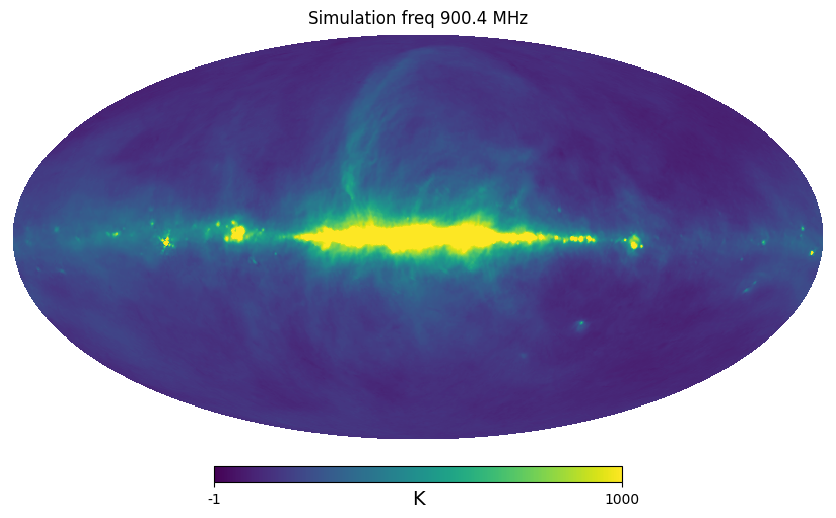

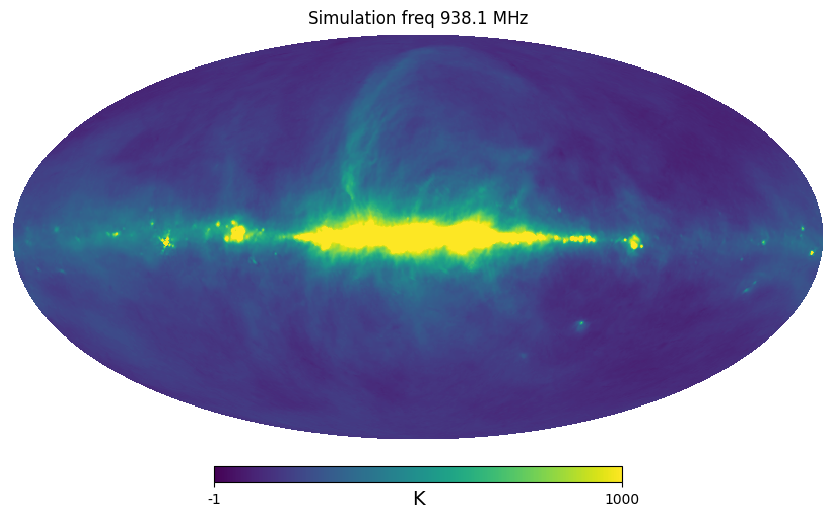

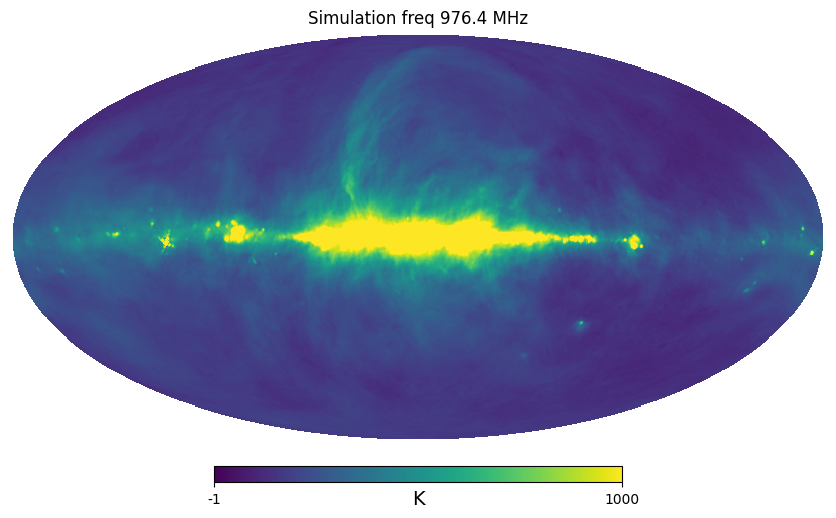

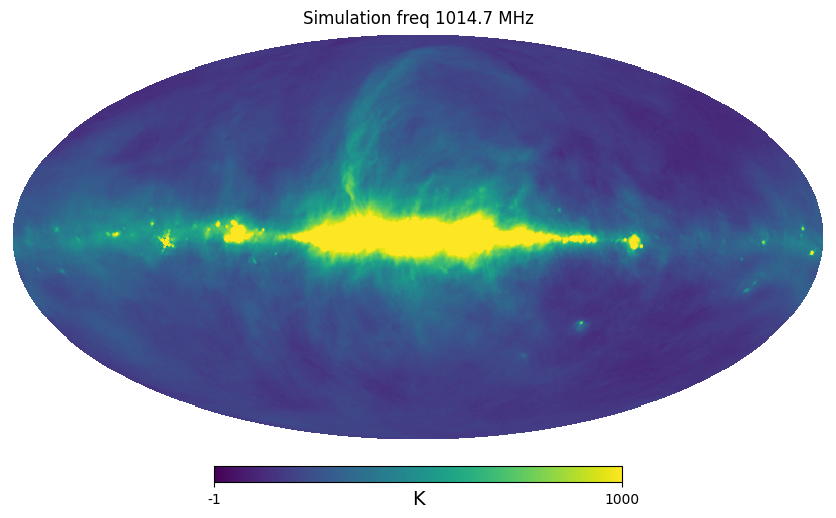

In [ ]:
# Pick 5 evenly spaced channels from the 177
indices = np.linspace(0, len(meerklass_freqs)-1, 4, dtype=int)

for idx in indices:
    freq = meerklass_freqs[idx]
    hp.mollview(data_cube[idx, :],
                title=f"Simulation freq {freq:.1f} MHz",
                cmap= "viridis",
                unit="K",
                min=-1, max=1000)
    plt.show()

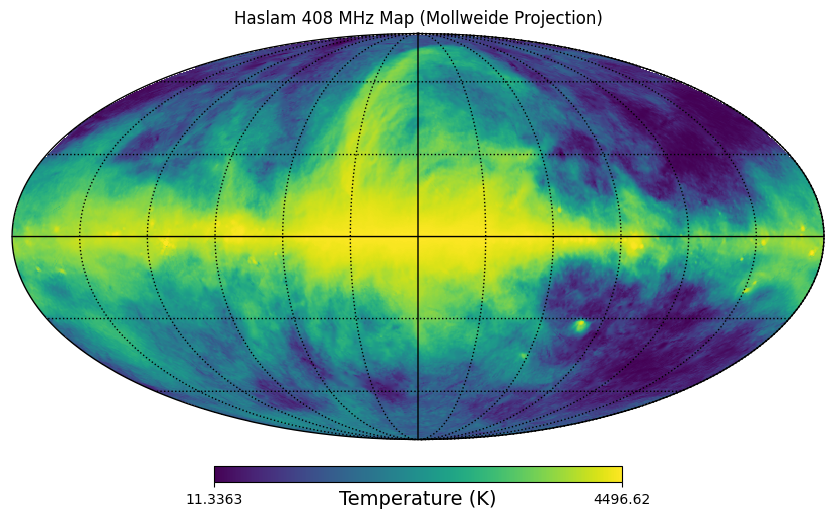

Temperature range: 10.98K to 4779.33K
Mean temperature: 34.41K


In [ ]:
# Convert structured array to plain numpy array
haslam_temp = haslam

# Create Mollweide projection
hp.mollview(haslam_temp, 
            title='Haslam 408 MHz Map (Mollweide Projection)',
            unit='Temperature (K)',
            norm='hist')
hp.graticule()
plt.show()

# basic statistics
print(f"Temperature range: {haslam_temp.min():.2f}K to {haslam_temp.max():.2f}K")
print(f"Mean temperature: {haslam_temp.mean():.2f}K")

### Angular power spectrum



In [ ]:
data_cube.shape

(177, 3145728)

In [ ]:
nside_target = 256
data_cube = np.array([
    hp.ud_grade(map_freq, nside_out= nside_target) for map_freq in data_cube
])

print("Cube shape after NSIDE downgrade:", data_cube.shape)            # (177, 786432)

Cube shape after NSIDE downgrade: (177, 786432)


In [ ]:
print(type(data_cube))
print(data_cube.shape)

<class 'numpy.ndarray'>
(177, 786432)


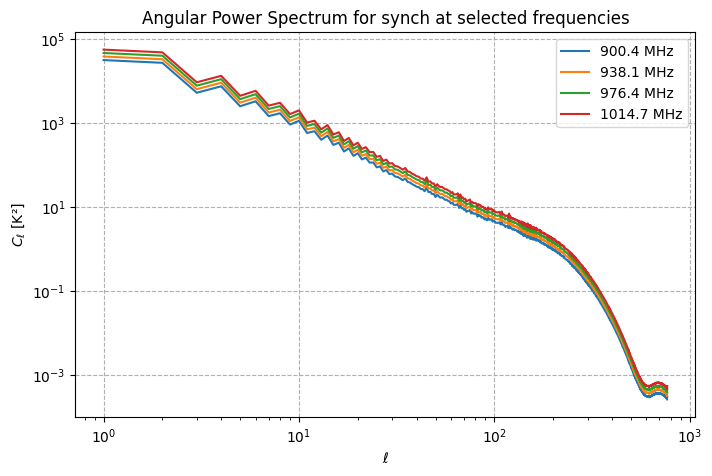

In [ ]:
# Anglar power-spectrum model
# Type of foreground to simulate. Possibilities are:
# 'galactic_synchrotron', 'galactic_freefree', 'extragalacit_freefree',
# 'point_sources' and 'custom'

'''cl_model = config['Parameters']['galactic_synchrotron']'''

# Cl model:
ell = np.arange(3*nside_target)               # placeholder, matches typical l range

plt.figure(figsize= (8,5))
for idx in indices:
    cl = hp.anafast(data_cube[idx, :])
    plt.loglog(np.arange(len(cl))[1:], cl[1:], label=f'{meerklass_freqs[idx]:.1f} MHz')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$ [K²]')
plt.title("Angular Power Spectrum for synch at selected frequencies")
plt.grid(True, ls= '--')
plt.legend()

plt.show()

In [ ]:
'''hp.mollview(data_cube[0,:], title=f"{meerklass_freqs[0]:.1f} MHz", unit='K')
hp.mollview(data_cube[len(meerklass_freqs)//2,:], title=f"{meerklass_freqs[len(meerklass_freqs)//2]:.1f} MHz", unit='K')'''

'hp.mollview(data_cube[0,:], title=f"{meerklass_freqs[0]:.1f} MHz", unit=\'K\')\nhp.mollview(data_cube[len(meerklass_freqs)//2,:], title=f"{meerklass_freqs[len(meerklass_freqs)//2]:.1f} MHz", unit=\'K\')'

#### Masking the bright galactic plane

###

In [ ]:
# Create a full-sky mask (all pixels valid) except for galactic plane
def gal_mask(rangelon=20, trans=5, nside=256, nest=False):

    '''
    Create a galactic plane mask with smooth transition.

    Parameters
    ----------
    rangelon : float
        Latitude cut in degrees (mask within |b| < rangelon).
    trans : float
        Transition width in degrees for smooth edge.
    nside : int
        Healpix NSIDE.
    nest : bool
        NESTED indexing if True, RING if False.

    Returns
    -------
    mask : ndarray
        1D HEALPix mask array (npix,)
    '''
    
    npix = hp.nside2npix(nside)
    theta, phi = hp.pix2ang(nside, np.arange(npix), nest=nest)
    
    # Convert colatitude (theta) to Galactic latitude
    lat_deg = 90.0 - np.degrees(theta)  
    lat_deg = np.abs(lat_deg)           # symmetric wrt Galactic plane
    
    mask = np.zeros(npix)
    mask[lat_deg > (rangelon + trans)] = 1.0

    # Smooth transition region
    if trans > 0:
        transition_pixels = (lat_deg >= rangelon) & (lat_deg <= (rangelon + trans))
        x = np.pi * (lat_deg[transition_pixels] - rangelon) / (2.0*trans)
        mask[transition_pixels] = np.sin(x) ** 2
    
    return mask

In [ ]:
# Apply mask func to foreground cube
mask = gal_mask(rangelon= 20, trans= 5, nside= 256)

foreground_masked = data_cube * mask[np.newaxis, :]

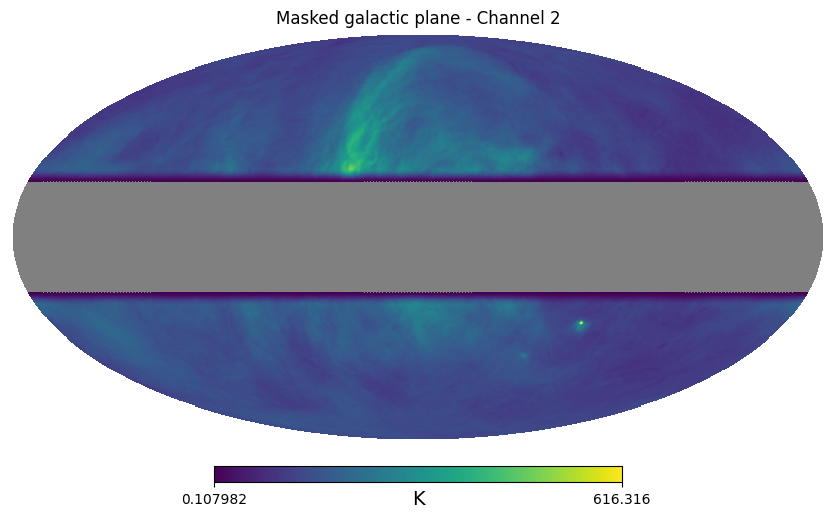

In [ ]:
# plot masked data
nu = 2            # chan 100

foreground_masked_hp = np.copy(foreground_masked)
foreground_masked_hp[foreground_masked == 0] = hp.UNSEEN 

hp.mollview(foreground_masked_hp[nu], 
            title=f'Masked galactic plane - Channel {nu}', 
            unit='K', 
            cmap='viridis',
            badcolor='Grey')

plt.show()

###

##

In [ ]:
# load the HI signal

path_HI = '../data/seed_1681/'
nutable_HI = np.loadtxt(path_HI + 'HI_nuTable.dat')

files = sorted(glob.glob(path_HI + "HI_*.fits"))

print('Number of channels:', len(files))
print('Frequencies (MHz):', nutable_HI[:10], '...')

# read all into a cube
HI_maps = []
for f in files:
    m = hp.read_map(f, verbose=False)  # 1D HEALPix array
    HI_maps.append(m)

HI_maps = np.array(HI_maps)  # shape: (N_channels, N_pix)

#print("Cube shape:", HI_maps.shape)

Number of channels: 670
Frequencies (MHz): [[  1.       580.       580.649254   1.446237   1.448975]
 [  2.       580.649254 581.298507   1.443505   1.446237]
 [  3.       581.298507 581.947761   1.440779   1.443505]
 [  4.       581.947761 582.597015   1.438059   1.440779]
 [  5.       582.597015 583.246269   1.435345   1.438059]
 [  6.       583.246269 583.895522   1.432637   1.435345]
 [  7.       583.895522 584.544776   1.429935   1.432637]
 [  8.       584.544776 585.19403    1.427239   1.429935]
 [  9.       585.19403  585.843284   1.424549   1.427239]
 [ 10.       585.843284 586.492537   1.421865   1.424549]] ...


/tmp/ipykernel_4183184/2838927791.py:14: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  m = hp.read_map(f, verbose=False)  # 1D HEALPix array


###

#### Cube shape: (670, 786432) for HI

670 = number of frequency channels (670 slices of the sky at different ν / redshift)

786432 = number of pixels per sky map. That’s consistent with nside = 256


In [ ]:
print(f'The shape for nu is {nutable_HI.shape}')

The shape for nu is (670, 5)


Channel index

Lower frequency edge (MHz)

Upper frequency edge (MHz)

Lower redshift

Upper redshift

#### Info contained in each row

In [ ]:
# range of nu for MeerKLASS
# freq 900 MHz - 1200 MHz
# Lets observe range from Felicia's data
print("Min freq:", nutable_HI[:,1].min())
print("Max freq:", nutable_HI[:,2].max())
print(f'The Nside: {hp.get_nside(HI_maps[0])}')

Min freq: 580.0
Max freq: 1015.0
The Nside: 256


In [ ]:
nu_low = nutable_HI[:,1]
nu_high = nutable_HI[:,2]
nu_mid = 0.5*(nu_low + nu_high)           # Mid nu MHz
nchan, npix = HI_maps.shape


# UHF 
target_low = 700.0
target_high = 1015.0

idxs = np.where((nu_mid >= target_low) & (nu_mid <= target_high))[0]
print("Selected channels:", idxs.size, "indices from", idxs[:5], "...", idxs[-5:])

# If none found, get nearest channels
if idxs.size == 0:
    nearest = np.argmin(np.abs(nu_mid - 0.5*(target_low+target_high)))
    print("No exact channels in band. Nearest channel:", nearest, "nu_mid=", nu_mid[nearest])

# build subcube 
sub_maps = HI_maps[idxs]           # shape (nsel, npix)
sub_nu_mid = nu_mid[idxs]

print("Subcube shape:", sub_maps.shape)

Selected channels: 485 indices from [185 186 187 188 189] ... [665 666 667 668 669]
Subcube shape: (485, 786432)


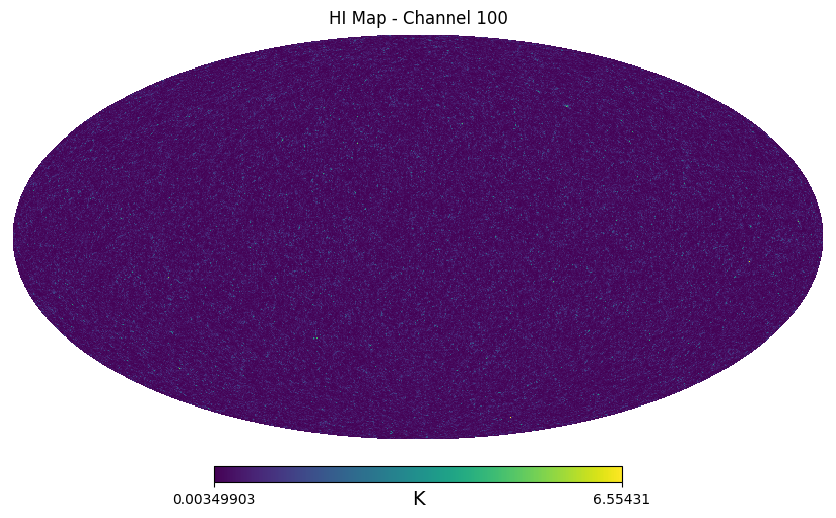

In [ ]:
i = 100

hp.mollview(HI_maps[i], title=f'HI Map - Channel {i}', unit='K')
plt.show()

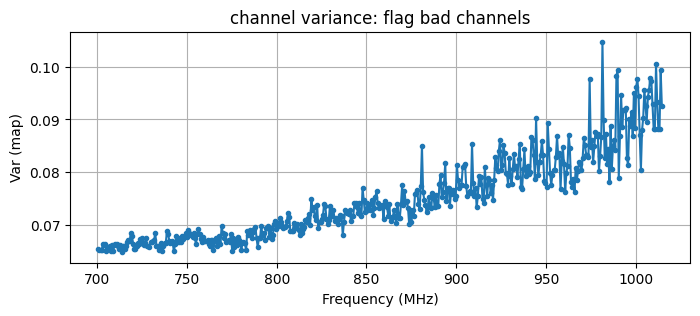

In [ ]:
# check per-channel variance
vars_per_chan = np.var(sub_maps, axis= 1)
plt.figure(figsize=(8,3))
plt.plot(sub_nu_mid, vars_per_chan, marker='.')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Var (map)")
plt.title("channel variance: flag bad channels")
plt.grid(True)
plt.show()

#### Angular power spectrum $C_{\ell}$ for HI map


In [ ]:
nutable_HI_1D = nutable.copy().flatten()

In [ ]:
nutable_HI_1D

array([1.00000000e+00, 5.80000000e+02, 5.80649254e+02, ...,
       1.01500000e+03, 3.99415000e-01, 4.00310000e-01])

In [ ]:
'''nside = 256
ell_max = 2 * nside  

plt.figure(figsize=(8,6))

# Chan
sample_idxs = np.linspace(0, HI_maps.shape[0]-1, 2, dtype=int)

for i in sample_idxs:
    freq_mhz = nutable_HI_1D[i]  # in MHz
    
    # Compute C_ell
    cl_hi = hp.anafast(HI_maps[i], lmax=ell_max)
    ell = np.arange(len(cl_hi))
    
    plt.loglog(ell[1:], cl_hi[1:], label=f'21 cm @ {freq_mhz:.1f} MHz')

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$ [K$^2$]')
plt.title('Angular Power Spectrum of 21 cm HI Maps')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()'''

"nside = 256\nell_max = 2 * nside  \n\nplt.figure(figsize=(8,6))\n\n# Chan\nsample_idxs = np.linspace(0, HI_maps.shape[0]-1, 2, dtype=int)\n\nfor i in sample_idxs:\n    freq_mhz = nutable_HI_1D[i]  # in MHz\n    \n    # Compute C_ell\n    cl_hi = hp.anafast(HI_maps[i], lmax=ell_max)\n    ell = np.arange(len(cl_hi))\n    \n    plt.loglog(ell[1:], cl_hi[1:], label=f'21 cm @ {freq_mhz:.1f} MHz')\n\nplt.xlabel(r'Multipole $\\ell$')\nplt.ylabel(r'$C_\\ell$ [K$^2$]')\nplt.title('Angular Power Spectrum of 21 cm HI Maps')\nplt.legend()\nplt.grid(True, which='both', ls='--', alpha=0.5)\nplt.show()"

Selected 485 channels between 700.0-1015.0 MHz


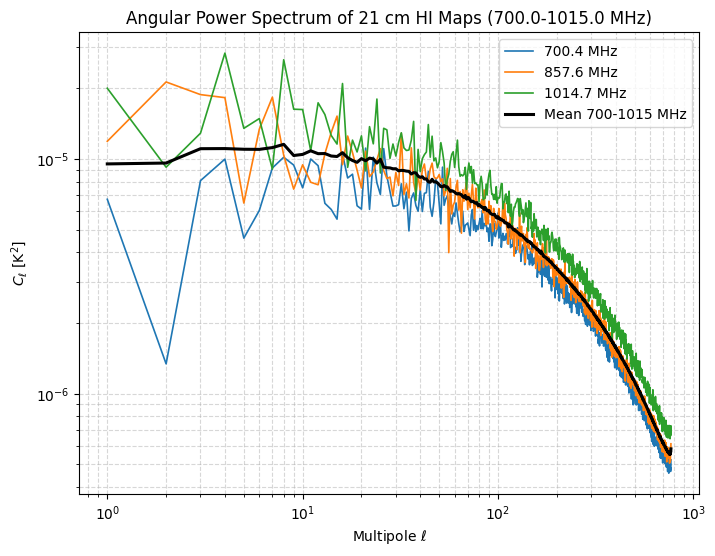

In [ ]:
nside = 256
ell_max = 3 * nside

plt.figure(figsize=(8,6))

# uhf
target_low, target_high = 700.0, 1015.0  

# Select indices
idxs = np.where((nu_mid >= target_low) & (nu_mid <= target_high))[0]

print(f"Selected {len(idxs)} channels between {target_low}-{target_high} MHz")

# 3 channels
sample_idxs = [idxs[0], idxs[len(idxs)//2], idxs[-1]]

cl_stack = []
for j in idxs:
    cl_stack.append(hp.anafast(HI_maps[j], lmax=ell_max))

# Plot cl
for j in sample_idxs:
    cl_hi = hp.anafast(HI_maps[j], lmax=ell_max)
    ell = np.arange(len(cl_hi))
    plt.loglog(ell[1:], cl_hi[1:], lw=1.2, 
               label=f'{nu_mid[j]:.1f} MHz')

# Mean spectrum
cl_stack = np.array(cl_stack)
cl_mean = np.mean(cl_stack, axis=0)
plt.loglog(ell[1:], cl_mean[1:], 'k', lw=2.2, 
           label=f'Mean {target_low:.0f}-{target_high:.0f} MHz')

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$ [K$^2$]')
plt.title(f'Angular Power Spectrum of 21 cm HI Maps ({target_low}-{target_high} MHz)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()


#### Merging HI with synch

In [ ]:
'''merged_cube = foreground_masked + HI_maps'''

'merged_cube = foreground_masked + HI_maps'